# Time Series Forecasting

# Import Data and Packages

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

# from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_store = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_trans = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

# Data overview and Visualizations

### Go through df_train
---
**Data description**
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [4]:
df_train = df_train.set_index(['date'])
# convert date index to datetime datatype
df_train.index = pd.to_datetime(df_train.index)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [6]:
df_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [7]:
df_sales = pd.DataFrame(df_train['sales'].groupby(df_train.index).sum(), columns=['sales'])

In [8]:
# convert date index to datetime datatype
df_sales.index = pd.to_datetime(df_sales.index)

In [9]:
# group as monthly
df_sales_M = df_sales.resample('M').sum()

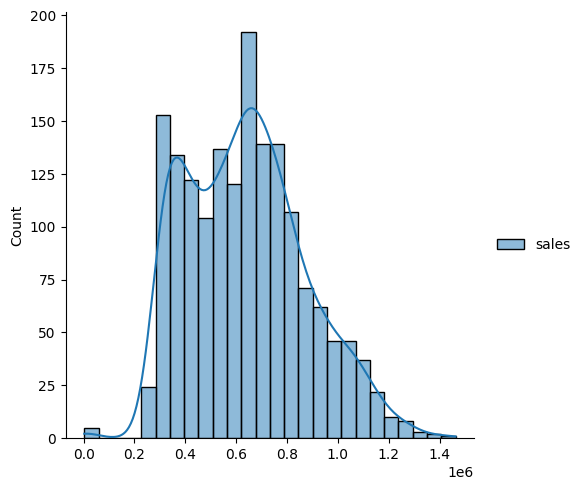

In [10]:
sns.displot(data=df_sales, kde=True);

<Axes: xlabel='date', ylabel='sales'>

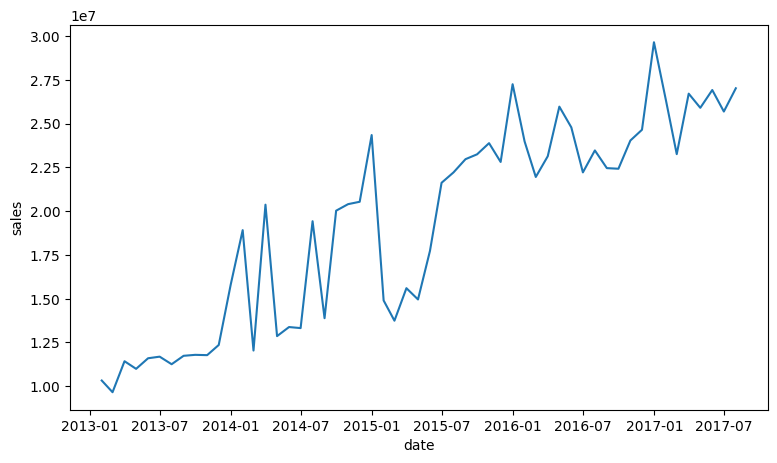

In [11]:
plt.figure(figsize=(9,5))
sns.lineplot(data=df_sales_M[:-1], x='date', y='sales')

### Go through holiday

---
**data description:**
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [12]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [13]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [14]:
df_holiday = df_holiday.set_index(['date'])
# convert date index to datetime datatype
df_holiday.index = pd.to_datetime(df_holiday.index)

In [15]:
df_holiday['transferred'].value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

Since some real holiday is transfered to the other day, try delete (transfered=True) rows

In [16]:
df_holiday = df_holiday[df_holiday['transferred']!=True]

### Go through store
---
**data description:**
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [17]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [18]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Go through df_trans
---


In [19]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Go through df_oil
---
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [20]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [21]:
df_oil = df_oil.set_index('date')
# convert date index to datetime datatype
df_oil.index = pd.to_datetime(df_oil.index)

In [22]:
# group as monthly
df_oil_M = df_oil.resample('M').mean()

<Axes: xlabel='date', ylabel='dcoilwtico'>

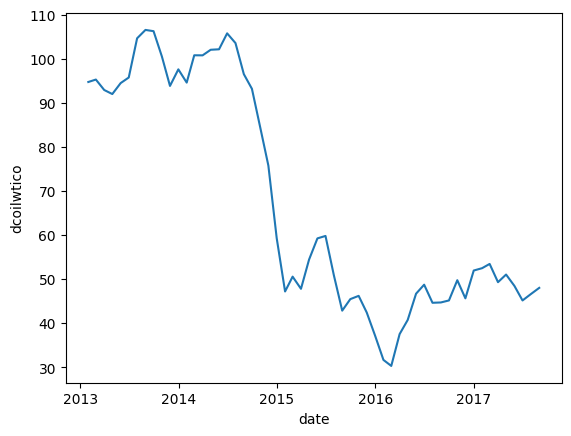

In [23]:
sns.lineplot(data=df_oil_M, x='date', y='dcoilwtico')

# Data Preprocessing

### Clean/Combine df_train, df_test

In [24]:
#df_train = df_train.set_index(['date'])
# convert date index to datetime datatype
df_train.index = pd.to_datetime(df_train.index)

df_test = df_test.set_index(['date'])
# convert date index to datetime datatype
df_test.index = pd.to_datetime(df_test.index)

In [25]:
df_test['test'] = 1
df_train['test'] = 0

In [26]:
# combine train and test to do feture engineering later
df_all = pd.concat([df_train, df_test])

### df_holiday

In [27]:
df_holiday['locale_name']


date
2012-03-02       Manta
2012-04-01    Cotopaxi
2012-04-12      Cuenca
2012-04-14    Libertad
2012-04-21    Riobamba
                ...   
2017-12-22     Ecuador
2017-12-23     Ecuador
2017-12-24     Ecuador
2017-12-25     Ecuador
2017-12-26     Ecuador
Name: locale_name, Length: 338, dtype: object

In [28]:
df_holiday.columns

Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [29]:
# keep the date that actually holiday
df_holiday = df_holiday[df_holiday['transferred']!=True]
# rename 'transferred'
df_holiday = df_holiday.rename(columns={'transferred':'holiday'})
df_holiday['holiday'] = 1
# drop some columns not useful later
df_holiday = df_holiday.drop(['type', 'description'], axis=1)
df_holiday

,locale,locale_name,holiday
date,,,
2012-03-02,Local,Manta,1
2012-04-01,Regional,Cotopaxi,1
2012-04-12,Local,Cuenca,1
2012-04-14,Local,Libertad,1
2012-04-21,Local,Riobamba,1
...,...,...,...
2017-12-22,National,Ecuador,1
2017-12-23,National,Ecuador,1
2017-12-24,National,Ecuador,1


In [30]:
merged_df = df_all.join(df_holiday, how='outer')
merged_df

,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday
date,,,,,,,,,
2012-03-02,NaN,NaN,NaN,NaN,NaN,NaN,Local,Manta,1.0
2012-04-01,NaN,NaN,NaN,NaN,NaN,NaN,Regional,Cotopaxi,1.0
2012-04-12,NaN,NaN,NaN,NaN,NaN,NaN,Local,Cuenca,1.0
2012-04-14,NaN,NaN,NaN,NaN,NaN,NaN,Local,Libertad,1.0
2012-04-21,NaN,NaN,NaN,NaN,NaN,NaN,Local,Riobamba,1.0
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,National,Ecuador,1.0
2017-12-23,NaN,NaN,NaN,NaN,NaN,NaN,National,Ecuador,1.0
2017-12-24,NaN,NaN,NaN,NaN,NaN,NaN,National,Ecuador,1.0


In [31]:
merged_df = merged_df.loc[merged_df['id'].notnull()]

In [32]:
merged_df.loc[:, 'locale'] = merged_df['locale'].fillna('')
merged_df.loc[:, 'locale_name'] = merged_df['locale_name'].fillna('')

In [33]:
# check missing data
null_count = merged_df.isnull().sum().sort_values(ascending=False)
ratio = (merged_df.isnull().sum()/merged_df.isnull().count()).sort_values(ascending=False)
missing_columns_count = pd.concat([null_count, ratio], axis=1, keys=['Total', 'Ratio'])
missing_columns_count.head(40)

,Total,Ratio
holiday,2594592,0.841618
sales,28512,0.009249
id,0,0.000000
store_nbr,0,0.000000
family,0,0.000000
onpromotion,0,0.000000
test,0,0.000000
locale,0,0.000000
locale_name,0,0.000000


In [34]:
merged_df.loc[:, 'store_nbr'] = merged_df['store_nbr'].astype('int')
merged_df.loc[:, 'onpromotion'] = merged_df['onpromotion'].astype('int')

In [35]:
# keep date column
merged_df = merged_df.reset_index()

In [36]:
merged_df

,date,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,0.0,National,Ecuador,1.0
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,0.0,National,Ecuador,1.0
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,0.0,National,Ecuador,1.0
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,0.0,National,Ecuador,1.0
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,0.0,National,Ecuador,1.0
...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,3029395.0,9.0,POULTRY,NaN,1.0,1.0,,,NaN
3082856,2017-08-31,3029396.0,9.0,PREPARED FOODS,NaN,0.0,1.0,,,NaN
3082857,2017-08-31,3029397.0,9.0,PRODUCE,NaN,1.0,1.0,,,NaN
3082858,2017-08-31,3029398.0,9.0,SCHOOL AND OFFICE SUPPLIES,NaN,9.0,1.0,,,NaN


### df_store, check holidays' city/state and stores' locale_name

In [37]:
merged_df = pd.merge(merged_df, df_store, on='store_nbr', how='outer')
merged_df

,date,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday,city,state,type,cluster
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,3029395.0,9.0,POULTRY,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6
3082856,2017-08-31,3029396.0,9.0,PREPARED FOODS,NaN,0.0,1.0,,,NaN,Quito,Pichincha,B,6
3082857,2017-08-31,3029397.0,9.0,PRODUCE,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6
3082858,2017-08-31,3029398.0,9.0,SCHOOL AND OFFICE SUPPLIES,NaN,9.0,1.0,,,NaN,Quito,Pichincha,B,6


In [38]:
# check missing data
null_count = merged_df.isnull().sum().sort_values(ascending=False)
ratio = (merged_df.isnull().sum()/merged_df.isnull().count()).sort_values(ascending=False)
missing_columns_count = pd.concat([null_count, ratio], axis=1, keys=['Total', 'Ratio'])
missing_columns_count.head(40)

,Total,Ratio
holiday,2594592,0.841618
sales,28512,0.009249
date,0,0.000000
id,0,0.000000
store_nbr,0,0.000000
family,0,0.000000
onpromotion,0,0.000000
test,0,0.000000
locale,0,0.000000
locale_name,0,0.000000


### find local holidays in local stores

In [39]:
# check if locale_name contains city or state
check_contains_city = lambda row: row['city'] in row['locale_name']
check_contains_state = lambda row: row['state'] in row['locale_name']
# 
merged_df['contains_city'] = merged_df.apply(check_contains_city, axis=1)
merged_df['contains_state'] = merged_df.apply(check_contains_state, axis=1)

In [40]:
merged_df['contains_state'].value_counts()

contains_state
False    3081540
True        1320
Name: count, dtype: int64

### combine df_trans

In [41]:
df_trans = df_trans.reset_index()
df_trans['date'] = pd.to_datetime(df_trans['date'])
df_trans = df_trans.drop(['index'], axis=1)

In [42]:
merged_df = pd.merge(merged_df, df_trans, on=['date', 'store_nbr'], how='outer')
merged_df

,date,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday,city,state,type,cluster,contains_city,contains_state,transactions
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13,False,False,NaN
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13,False,False,NaN
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13,False,False,NaN
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13,False,False,NaN
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,3029395.0,9.0,POULTRY,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6,False,False,NaN
3082856,2017-08-31,3029396.0,9.0,PREPARED FOODS,NaN,0.0,1.0,,,NaN,Quito,Pichincha,B,6,False,False,NaN
3082857,2017-08-31,3029397.0,9.0,PRODUCE,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6,False,False,NaN
3082858,2017-08-31,3029398.0,9.0,SCHOOL AND OFFICE SUPPLIES,NaN,9.0,1.0,,,NaN,Quito,Pichincha,B,6,False,False,NaN


In [43]:
# missing data
merged_df.loc[:, 'transactions'] = merged_df['transactions'].fillna('')

### df_oil

In [44]:
df_oil = df_oil.reset_index()

In [45]:
merged_df = pd.merge(merged_df, df_oil, on=['date'], how='outer')
merged_df

,date,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday,city,state,type,cluster,contains_city,contains_state,transactions,dcoilwtico
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082858,2017-08-31,3029398.0,9.0,SCHOOL AND OFFICE SUPPLIES,NaN,9.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26
3082859,2017-08-31,3029399.0,9.0,SEAFOOD,NaN,0.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26
3082860,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082861,2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check missing values, and clean data

In [46]:
# check missing data
null_count = merged_df.isnull().sum().sort_values(ascending=False)
ratio = (merged_df.isnull().sum()/merged_df.isnull().count()).sort_values(ascending=False)
missing_columns_count = pd.concat([null_count, ratio], axis=1, keys=['Total', 'Ratio'])
missing_columns_count.head(40)

,Total,Ratio
holiday,2594595,8.416187e-01
dcoilwtico,962283,3.121394e-01
sales,28515,9.249519e-03
store_nbr,3,9.731214e-07
family,3,9.731214e-07
onpromotion,3,9.731214e-07
test,3,9.731214e-07
locale,3,9.731214e-07
locale_name,3,9.731214e-07
id,3,9.731214e-07


In [47]:
merged_df = merged_df.loc[merged_df['id'].notnull()]

In [48]:
merged_df

,date,id,store_nbr,family,sales,onpromotion,test,locale,locale_name,holiday,city,state,type,cluster,contains_city,contains_state,transactions,dcoilwtico
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,0.0,National,Ecuador,1.0,Quito,Pichincha,D,13.0,False,False,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,3029395.0,9.0,POULTRY,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26
3082856,2017-08-31,3029396.0,9.0,PREPARED FOODS,NaN,0.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26
3082857,2017-08-31,3029397.0,9.0,PRODUCE,NaN,1.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26
3082858,2017-08-31,3029398.0,9.0,SCHOOL AND OFFICE SUPPLIES,NaN,9.0,1.0,,,NaN,Quito,Pichincha,B,6.0,False,False,,47.26


In [49]:
merged_df.loc[:, 'holiday'] = merged_df['holiday'].fillna(0)

In [50]:
# weekend
merged_df.loc[:, 'weekday'] = merged_df['date'].dt.weekday

/tmp/ipykernel_18/4014187736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.loc[:, 'weekday'] = merged_df['date'].dt.weekday


In [51]:
merged_df.loc[:, 'weekend_holi'] = (merged_df['weekday'].isin([5, 6])) | (merged_df['holiday'] == 1.0)

/tmp/ipykernel_18/3536395785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.loc[:, 'weekend_holi'] = (merged_df['weekday'].isin([5, 6])) | (merged_df['holiday'] == 1.0)


In [52]:
merged_df['weekend_holi'].value_counts()

weekend_holi
False    1856844
True     1226016
Name: count, dtype: int64

In [53]:
# Interpolation oil price
merged_df['dcoilwtico'] = merged_df['dcoilwtico'].interpolate()

# Backward Fill the first day missing oil price
merged_df['dcoilwtico'] = merged_df['dcoilwtico'].fillna(method='bfill')

/tmp/ipykernel_18/2402107974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['dcoilwtico'] = merged_df['dcoilwtico'].interpolate()
/tmp/ipykernel_18/2402107974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['dcoilwtico'] = merged_df['dcoilwtico'].fillna(method='bfill')


In [54]:
#missing data
null_count = merged_df.isnull().sum().sort_values(ascending=False)
ratio = (merged_df.isnull().sum()/merged_df.isnull().count()).sort_values(ascending=False)
missing_columns_count = pd.concat([null_count, ratio], axis=1, keys=['Total', 'Ratio'])
missing_columns_count.head(40)

,Total,Ratio
sales,28512,0.009249
date,0,0.000000
state,0,0.000000
weekday,0,0.000000
dcoilwtico,0,0.000000
transactions,0,0.000000
contains_state,0,0.000000
contains_city,0,0.000000
cluster,0,0.000000
type,0,0.000000


### Check data type

In [55]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082860 entries, 0 to 3082859
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   id              float64       
 2   store_nbr       float64       
 3   family          object        
 4   sales           float64       
 5   onpromotion     float64       
 6   test            float64       
 7   locale          object        
 8   locale_name     object        
 9   holiday         float64       
 10  city            object        
 11  state           object        
 12  type            object        
 13  cluster         float64       
 14  contains_city   object        
 15  contains_state  object        
 16  transactions    object        
 17  dcoilwtico      float64       
 18  weekday         int32         
 19  weekend_holi    bool          
dtypes: bool(1), datetime64[ns](1), float64(8), int32(1), object(9)
memory usage: 461.6+ MB


In [56]:
# 设置条件：'locale' 是 'Local' 或 'Regional'，且 'contains_city' 和 'contains_state' 都是 False
condition = merged_df['locale'].isin(['Local', 'Regional']) & ~(merged_df['contains_city'] | merged_df['contains_state'])

# 只更新符合条件且 'weekend_holi' 当前为 True 的行
merged_df.loc[condition & (merged_df['weekend_holi'] == True), 'weekend_holi'] = False

In [57]:
# set condition as locale name fits 'Local' or 'Regional' in holiday data
condition = (merged_df['weekend_holi'] == True) & merged_df['locale'].isin(['Local', 'Regional'])

# find if there's any fit and how many
count = merged_df[condition].shape[0]

print("Fit local name btw store place and local/regional holiday：", count)

Fit local name btw store place and local/regional holiday： 13233


### Drop unnecessary columns to save memory

In [58]:
merged_df = merged_df.drop(['test', 'locale', 'locale_name', 'holiday', 'city', 'state', 'contains_city', 'contains_state', 'weekday'], axis=1)

In [59]:
merged_df['transactions'] = merged_df['transactions'].replace('', 0)

In [60]:
merged_df['date'] = merged_df['date'].dt.strftime("%Y%m%d").astype(int)
merged_df['store_nbr'] = merged_df['store_nbr'].astype('int')
merged_df['transactions'] = merged_df['transactions'].astype('int')
merged_df['weekend_holi'] = merged_df['weekend_holi'].astype('int')

In [61]:
# Encode labels

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

#merged_df['date_encoded'] = label_encoder.fit_transform(merged_df['date'])
merged_df['family_encoded'] = label_encoder.fit_transform(merged_df['family'])
merged_df['type_encoded'] = label_encoder.fit_transform(merged_df['type'])
merged_df['onpromotion_encoded'] = label_encoder.fit_transform(merged_df['onpromotion'])
merged_df['cluster_encoded'] = label_encoder.fit_transform(merged_df['cluster'])

In [62]:
merged_df = merged_df.drop(['id', 'family', 'type', 'onpromotion', 'cluster'], axis=1)

In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082860 entries, 0 to 3082859
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 int64  
 1   store_nbr            int64  
 2   sales                float64
 3   transactions         int64  
 4   dcoilwtico           float64
 5   weekend_holi         int64  
 6   family_encoded       int64  
 7   type_encoded         int64  
 8   onpromotion_encoded  int64  
 9   cluster_encoded      int64  
dtypes: float64(2), int64(8)
memory usage: 258.7 MB


In [64]:
merged_df

,date,store_nbr,sales,transactions,dcoilwtico,weekend_holi,family_encoded,type_encoded,onpromotion_encoded,cluster_encoded
0,20130101,1,0.0,0,93.14,1,0,3,0,12
1,20130101,1,0.0,0,93.14,1,1,3,0,12
2,20130101,1,0.0,0,93.14,1,2,3,0,12
3,20130101,1,0.0,0,93.14,1,3,3,0,12
4,20130101,1,0.0,0,93.14,1,4,3,0,12
...,...,...,...,...,...,...,...,...,...,...
3082855,20170831,9,NaN,0,47.26,0,28,1,1,5
3082856,20170831,9,NaN,0,47.26,0,29,1,0,5
3082857,20170831,9,NaN,0,47.26,0,30,1,1,5
3082858,20170831,9,NaN,0,47.26,0,31,1,9,5


## Split to train, valid, and test
- (to do) train deep learning model

In [65]:
df_train = merged_df.loc[merged_df['sales'].notnull()]
df_test = merged_df.loc[merged_df['sales'].isnull()]
df_test = df_test.drop(['sales'], axis=1)

In [66]:
# convert date index to datetime datatype
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y%m%d')

/tmp/ipykernel_18/376460148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')


In [67]:
df_train.groupby(df_train.date).mean()

,store_nbr,sales,transactions,dcoilwtico,weekend_holi,family_encoded,type_encoded,onpromotion_encoded,cluster_encoded
date,,,,,,,,,
2013-01-01,27.5,1.409438,14.259259,93.140000,1.000000,16.0,2.0,0.000000,7.481481
2013-01-02,27.5,278.390807,1726.203704,93.140000,0.000000,16.0,2.0,0.000000,7.481481
2013-01-03,27.5,202.840197,1453.777778,92.970000,0.000000,16.0,2.0,0.000000,7.481481
2013-01-04,27.5,198.911154,1453.592593,93.120000,0.000000,16.0,2.0,0.000000,7.481481
2013-01-05,27.5,267.873244,1732.833333,93.140006,1.000000,16.0,2.0,0.000000,7.481481
...,...,...,...,...,...,...,...,...,...
2017-08-11,27.5,463.733851,1658.351852,48.810000,1.000000,16.0,2.0,7.956790,7.481481
2017-08-12,27.5,444.798280,1665.314815,48.504914,1.000000,16.0,2.0,4.664422,7.481481
2017-08-13,27.5,485.768618,1592.462963,47.895086,1.000000,16.0,2.0,5.209315,7.481481


### Prepare data for VAR model

In [68]:
df_grouptrain = df_train.groupby(df_train.date).mean()
df_grouptrain = df_grouptrain.drop(['store_nbr', 'family_encoded', 'type_encoded', 'cluster_encoded'], axis=1)

In [69]:
df_grouptrain

,sales,transactions,dcoilwtico,weekend_holi,onpromotion_encoded
date,,,,,
2013-01-01,1.409438,14.259259,93.140000,1.000000,0.000000
2013-01-02,278.390807,1726.203704,93.140000,0.000000,0.000000
2013-01-03,202.840197,1453.777778,92.970000,0.000000,0.000000
2013-01-04,198.911154,1453.592593,93.120000,0.000000,0.000000
2013-01-05,267.873244,1732.833333,93.140006,1.000000,0.000000
...,...,...,...,...,...
2017-08-11,463.733851,1658.351852,48.810000,1.000000,7.956790
2017-08-12,444.798280,1665.314815,48.504914,1.000000,4.664422
2017-08-13,485.768618,1592.462963,47.895086,1.000000,5.209315


In [70]:
n_valid = 10
groupvalid = df_grouptrain[-n_valid:]
grouptrain = df_grouptrain[:-n_valid]
print('Valid shape:', groupvalid.shape)
print('Train shape', grouptrain.shape)

Valid shape: (10, 5)
Train shape (1674, 5)


# VAR Forecasting
- predict 10 periods

In [71]:
nobs = 10

In [72]:
# Check AIC and find the best lag order
aic_all_list = []
lag_order_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for order in lag_order_list:
    model = sm.tsa.VAR(grouptrain[:-nobs])
    result = model.fit(order)
    aic_all = result.aic
    aic_all_list.append(aic_all)
    print('VAR({}) - AIC All:{}'.format(order, aic_all))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR(1) - AIC All:16.938398507743745
VAR(2) - AIC All:16.11728264228674
VAR(3) - AIC All:15.65559914143497
VAR(4) - AIC All:15.380321805161758
VAR(5) - AIC All:14.970462690846222
VAR(6) - AIC All:14.64394681236562
VAR(7) - AIC All:13.50451721600791
VAR(8) - AIC All:13.224738758656573
VAR(9) - AIC All:13.142897098416864
VAR(10) - AIC All:13.113502711214554
VAR(11) - AIC All:13.11603217522463
VAR(12) - AIC All:13.101517641737411
VAR(13) - AIC All:13.057987733774857
VAR(14) - AIC All:12.978795591396679
VAR(15) - AIC All:12.971729740666065
VAR(16) - AIC All:12.96693067463815
VAR(17) - AIC All:12.978399269074897


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR(18) - AIC All:12.99436737180653
VAR(19) - AIC All:13.002354815614511
VAR(20) - AIC All:13.006785811220546


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [73]:
best_lag = lag_order_list[aic_all_list.index(np.min(aic_all_list))]

In [74]:
model = sm.tsa.VAR(grouptrain)
result = model.fit(best_lag)
lag_order = result.k_ar

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [75]:
forecast_input = grouptrain.values[-lag_order:]

In [76]:
fc = result.forecast(y=forecast_input, steps=nobs)
var_forecast = pd.DataFrame(fc, index=groupvalid.index,
                            columns=grouptrain.columns)

In [77]:
# MSE
print(sum((groupvalid['sales'] - var_forecast['sales'])**2))

35248.81924623842


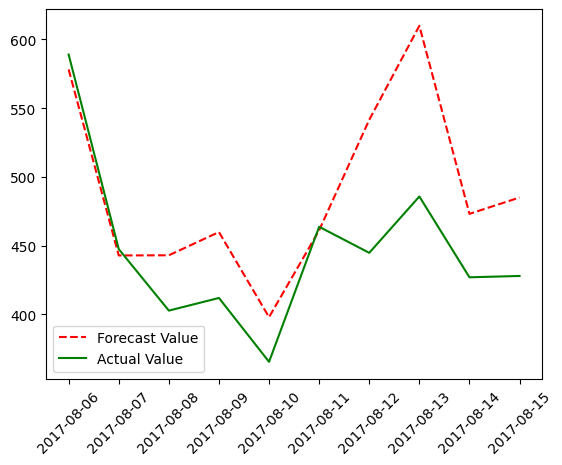

In [78]:
# plot prediction
plt.plot(groupvalid.index, var_forecast['sales'], color='r', linestyle='--', label='Forecast Value')
plt.plot(groupvalid.index, groupvalid['sales'], color='g', linestyle='-', label='Actual Value')
plt.xticks(rotation=45)
plt.legend()
plt.show()